## Multi-label prediction with Planet Amazon dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

## Getting the data

In [ ]:
#引用kaggle的資料源，而kaggle的資料下載需要安裝kaggle下載器來進行

The planet dataset isn't available on the [fastai dataset page](https://course.fast.ai/datasets) due to copyright restrictions. You can download it from Kaggle however. Let's see how to do this by using the [Kaggle API](https://github.com/Kaggle/kaggle-api) as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal (depending on your platform you may need to modify this slightly to either add `source activate fastai` or similar, or prefix `pip` with a path. Have a look at how `conda install` is called for your platform in the appropriate *Returning to work* section of https://course.fast.ai/. (Depending on your environment, you may also need to append "--user" to the command.)

In [3]:
! {sys.executable} -m pip install kaggle --upgrade

Requirement already up-to-date: kaggle in c:\users\user\anaconda3\envs\fastai_v1\lib\site-packages (1.5.6)


Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal). For Windows, uncomment the last two commands.

In [4]:
# ! mkdir -p ~/.kaggle/
# ! mv kaggle.json ~/.kaggle/

# For Windows, uncomment these two commands
! mkdir %userprofile%\.kaggle
! move kaggle.json %userprofile%\.kaggle

子目錄或檔案 C:\Users\User\.kaggle 已經存在。
系統找不到指定的檔案。


You're all set to download the data from [planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). You **first need to go to its main page and accept its rules**, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a `403 forbidden` error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on *Rules* tab, and then scroll to the bottom to find the *accept* button).

In [5]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

WindowsPath('C:/Users/User/.fastai/data/planet')

In [6]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space


####################################################疑問，404 - Not Found404 - Not Found無法downlload#########################################
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}

planet-understanding-the-amazon-from-space.zip: Skipping, found more recently modified local copy (use --force to force download)
404 - Not Found
404 - Not Found


To extract the content of this file, we'll need 7zip, so uncomment the following line if you need to install it (or run `sudo apt install p7zip-full` in your terminal).

In [7]:
##################################################疑問############################################################################
! conda install --yes --prefix {sys.prefix} -c haasad eidl7zip
! conda install -y -c haasad eidl7zip

Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.8.0
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base conda




Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.8.0
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base conda




And now we can unpack the data (uncomment to run - this might take a few minutes to complete).

In [8]:
########################################################疑問~~~~~~~~~~~###################################################################
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}


7-Zip (A) 9.20  Copyright (c) 1999-2010 Igor Pavlov  2010-11-18


Error:
cannot find archive


## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [ ]:
#可以觀察一下資料可以知道，一張圖或許擁有很多標籤
#pandas => pd ; 用pandas讀取.csv

In [15]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [10]:
#pandas.csv轉換成DataBunch
#將資料要餵給訓練網路遇到的問題很多，例如:文件在哪、數據格式、標籤資料形式、數據集分類、數據轉換等等
#DataBunch while using the fastai自創的"data block API"模組套件，使自己的資料集呼叫有更優質的彈性
#https://docs.fast.ai/data_block.html
#data = (ImageList.from_folder(path)    #Where to find the data? -> in path and its subfolders
#       .split_by_folder()              #How to split in train/valid? -> use the folders
#       .label_from_folder()            #How to label? -> depending on the folder of the filenames
#       .add_test_folder()              #Optionally add a test set (here default name is test)
#       .transform(tfms, size=64)       #Data augmentation? -> use tfms with a size of 64
#       .databunch())                   #Finally? -> use the defaults for conversion to ImageDataBunch

In [16]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [ ]:
#變形:默認的變形是隨機反轉每個圖片，但是只會水平隨機反轉。如果你要識別貓和狗，朝左朝右沒有關係，但是你不會希望它上下反轉。
#     對衛星圖來說，是否多雲，有霧，是否有道路顯然可以上下反轉。對空間來說沒有必須的方向。
#     所以我們不用flip_vert的False的默認值，要把它改成True，表示可以上下反轉。它不僅會上下反轉，還會嘗試每種90度旋轉（會嘗試8種可能的旋轉）

#Warp: 很少庫會提供Perspective warping功能，即使提供了也會很慢。我覺得fastai是第一個提供快速perspective warping的庫。
#      這個比較有意義的原因是，如果我在上方或者下方看你，你的形狀是不一樣的。
#      所以如果你對貓和狗拍照，有時會比較高，有時會比較矮，這種情況導致的形狀的改變，是你在創建batch時希望處理的，每次都修改一些。
#      對衛星圖來說不是這樣，衛星都是垂直向下拍攝。如果你加入perspective warping，你將加入現實中不存在的變形。所以要關閉它。

#這些都屬於數據增強（data augmentation）。後續我們還會講很多關於這個的內容。現在你可以開始了解下，用它來增強你的數據。
#通常，或許最重要的是，如果你的數據是天文數據，醫學影像或者衛星圖這種沒有上下之分的圖像，就把垂直反轉設成true，這通常會讓你的模型更好。

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [ ]:
# PyTorch裡的Dataset定義了兩個東西： __getitem__ 和 __len__
# 我的dataset的第3個數據是什麼（這是__getitem__做的）,我的dataset有多大（這是 __len__ 做的）

# 要訓練模型，dataset還不夠。如果你回想上週講的梯度下降，我們需要做的第一件事是，一次性取到一些圖片/數據，這樣GPU可以並行處理。
# 記得“mini-batch”嗎？ mini-batch是我們在同一批里傳給模型的一組數據，它們可以並行訓練。
# 要創建一個mini-batch，我們使用另外一個叫做DataLoader的PyTorch類
# DataLoader對像在構造函數里接收一個dataset。它現在說“噢，用這個，我可以取到第三個數據、第五個數據、第九個數據”。
# 它會：隨機抓取數據按照你要求的大小創建一個batch把它輸入進GPU把它發送到你的模型裡
# 所以DataLoader是一個可以抓取獨立數據，把它們組成一個mini-batch，輸入GPU來建模的東西。所以它被叫做DataLoader。它由一個Dataset生成。

# 要訓練模型只有這些還不夠，因為我們沒辦法驗證模型。如果我們只有訓練集，我們沒辦法知道我們模型怎麼樣，我們需要分離出一個驗證集，來檢查模型的效果。
# 我們用一個叫DataBunch的fastai類來做這個。 DataBunch把訓練數據的data loader（train_dl）和驗證數據的data loader（valid_dl）綁定在一起

In [17]:
#src = (ImageFileList.from_folder(path)
#       .label_from_csv('train_v2.csv', sep=' ', folder='train-jpg', suffix='.jpg')
#       .rand_split_by_pct(0.2))
#資料清單從csv轉換而來(路徑，檔案名稱，圖片檔案資料夾，圖檔案形式)，分驗證集的比例(0.2)20%，資料標籤分隔以空格方式區分
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [20]:
#data根據上述src加上tfms形式轉換再來.normalize而得(使用imagenet_stats均值和方差)
#參考http://localhost:8888/notebooks/course-v3/fastai-master/docs_src/data_block.ipynb

#對這個dataset，這個indexer返回了兩個東西：圖片和標籤（假設它是一個圖片dataset）
#圖片來自哪裡？
#標籤來自哪裡？
#然後我把數據分成訓練dataset和驗證
############################################以上為上欄內容#####################################
#.datasets() 把它們轉成PyTorch
#上欄src加上本欄第一行都還在dataset環境中

#.transform() 用來變形+mini-batch概念
#.databunch() 會一步創建DataLoader和DataBunch
#data = (src.dataset()
#        .transform(tfms, size=128)
#        .databunch().normalize(imagenet_stats))

data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

`show_batch` still works, and show us the different labels separated by `;`.

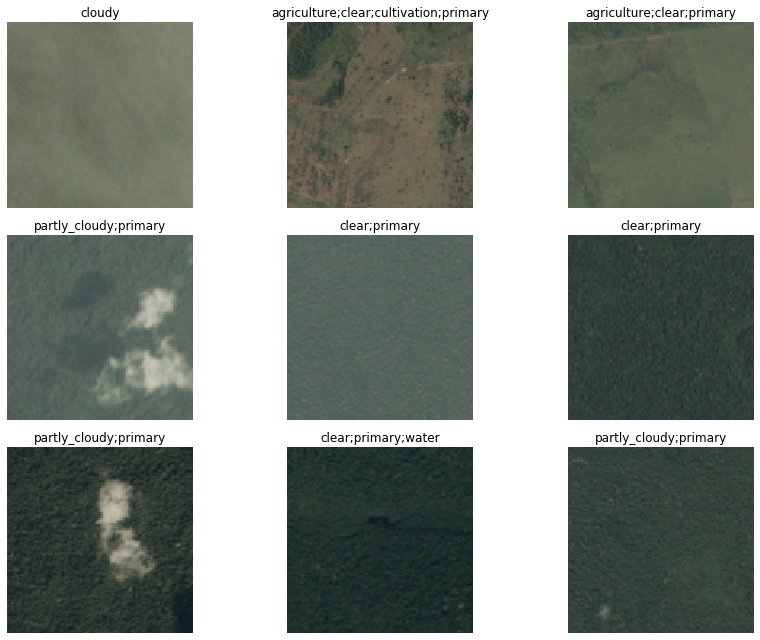

In [21]:
#show出資料的狀況、標籤
data.show_batch(rows=3, figsize=(12,9))

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet50 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [ ]:
#決定所用的模型

In [16]:
arch = models.resnet50

In [17]:
#F-score(thresh_float)
#accuracy準確度；F-score是kaggle競賽評斷訓練結果好壞方式
#accuracy是用argmax取最有可能解與真實差值均方，而這種方式無法適用於多重標籤數據上(data classes共有17種)，所以我們取thresh_float值用意在於
#當圖片判斷高於某個數值我們就認定該圖片也擁有該種分類；而經過我們的嘗試發現thresh_float取0.2擁有較佳的結果
#
#所以一普通的accuracy無法符合我們所用，我們創建另一種accuracy_thresh比較值(讓所有類別概率值與thresh_float值比較，回復所有比thresh_float大的值)
#accuracy_thresh=(thresh=0.2......)
# def acc_02(inp,targ): return accuracy_thresh=(inp,targ,thresh=0.2)
#然而這種一個function加上某種特定值組合而成另一種function在python3有一種函式"partial"可以做到；如下所示
acc_02 = partial(accuracy_thresh, thresh=0.2)
#F-score也用相同的方式同樣得比較著0.2
f_score = partial(fbeta, thresh=0.2)
#訓練，用cnn(資料，訓練架構，metrics=[acc_02, f_score])
#針對metrics的修改(並不是修改訓練過程或模型)，是修改訓練時所印出來的格式(印出accuracy及f_score)，所以改這對結果不變
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

We use the LR Finder to pick a good learning rate.

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


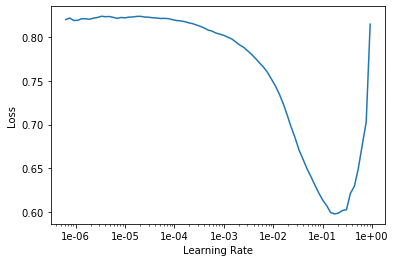

In [19]:
learn.recorder.plot()

In [ ]:
#這很簡單找最陡的斜坡，不是最底部。記住，我們要尋找快速下滑的位置。所以，如果你從底部開始，損失度會上升。
#解凍後再調用一次，你一般會得到一個非常不同的形狀。

Then we can fit the head of our network.

In [20]:
lr = 0.01

In [21]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.124183,0.110516,0.950086,0.902593,03:28
1,0.108227,0.099742,0.951844,0.914002,03:27
2,0.099500,0.090681,0.955644,0.921466,03:26
3,0.095105,0.088541,0.956880,0.922494,03:27
4,0.091859,0.086831,0.956189,0.924129,03:27


In [ ]:
#####部署好的app如果做了錯誤的預測，有沒有好的方法來記錄錯誤，針對性地改進模型？

#####首先是有沒有辦法記錄,這取決於你自己,預測錯時你需要讓用戶告訴你。所以首先,你需要收集這些回饋,然後你需要記錄在日誌裡,
#####一個記錄預測值和用戶說的實際值的文件。一天或者一周結束時，你可以用定時任務處理或者手工處理一下。做一些fine-tuning
#####假如這是你保存的模型：

In [22]:
learn.save('stage-1-rn50')

...And fine-tune the whole model:

In [ ]:
#我們解凍它：

In [23]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


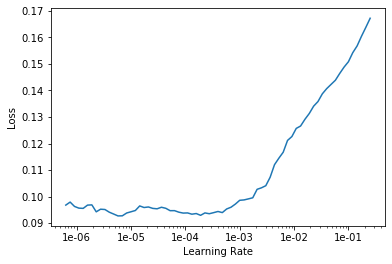

In [24]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
#上圖要找出合適的值有點難，因為它可能是這種形狀(有點向上，然後快速下降，然後再向上)
#我一般會找最低點，然後縮小10倍，這是一個經驗規則。所以選用1e-5做區間的開始值

#然後找區間的結束值，我一般參考解凍前的下降幅度大的值(lr=0.01)，在它的基礎上除以5或者10，基本是這個位置。這是我的經驗：

#{解凍後找到接近底部的位置，除以10，作為區間的最小值；解凍前的下降幅度大的值(lr=0.01)取lr/5 或者 lr/10 作為區間的最大值}
#這叫discriminative learning rates（差別學習率），後續課程裡還會介紹。

In [ ]:
#####然後再訓練一次。這裡，我使用的是原來的數據。但是你可以使用分錯的數據創建一個新的data bunch，用它來執行fit。
#####判斷錯誤的數據是需要特別關注的。所以你可能需要用稍微高些的學習率，或者多訓練幾輪。你只需要用出錯圖片和修正的分類來訓練。這能有效改進模型。

In [25]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.096332,0.091429,0.954620,0.919761,03:48
1,0.096712,0.089977,0.953966,0.922935,03:48
2,0.091151,0.086023,0.956415,0.925868,03:49
3,0.085926,0.082596,0.957229,0.929387,03:53
4,0.080223,0.082663,0.958602,0.928845,03:49


In [26]:
learn.save('stage-2-rn50')

In [27]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [28]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


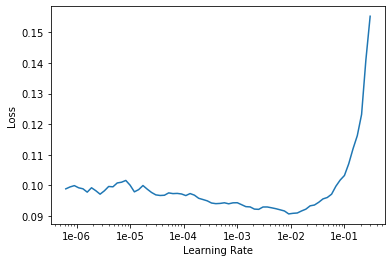

In [29]:
learn.lr_find()
learn.recorder.plot()

In [30]:
lr=1e-2/2

In [31]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.088839,0.085883,0.956320,0.926202,05:29
1,0.084494,0.086173,0.957359,0.923186,05:35
2,0.083523,0.082291,0.959547,0.928995,05:34
3,0.080677,0.081768,0.959881,0.929944,05:35
4,0.079400,0.080990,0.959481,0.930857,05:35


In [32]:
learn.save('stage-1-256-rn50')

In [33]:
learn.unfreeze()

In [34]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.081215,0.083806,0.958900,0.928576,06:30
1,0.083109,0.083018,0.957643,0.929747,06:29
2,0.082280,0.082852,0.959234,0.928099,06:28
3,0.078707,0.081388,0.958420,0.929829,06:29
4,0.075888,0.081128,0.958842,0.929963,06:30


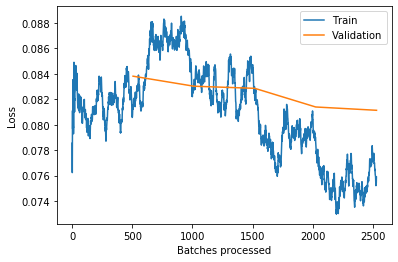

In [35]:
learn.recorder.plot_losses()

In [36]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [37]:
learn.export()

In [ ]:
#https://docs.fast.ai/data_block.html#Examples-of-use
#提問： 能不能多講講data block的理念？我不明白它是用來做什麼的。需要按固定的順序使用嗎？有沒有其他使用這種方法的庫能讓我看下？

#需要按照固定順序使用它們。你可以在使用示例裡看到順序。

#data = (ImageItemList.from_folder(path)  #Where to find the data? -> in path and its subfolders
#        .split_by_folder()               #How to split in train/valid? -> use the folders
#        .label_from_folder()             #How to label? -> depending on the folder of the filenames
#        .add_test_folder()               #Optionally add a test set (here default name is test)
#        .transform(tfms, size=64)        #Data augmentation? -> use tfms with a size of 64
#        .databunch())                    #Finally? -> use the defaults for conversion to ImageDataBunch

#你的數據是什麼類型的？
#它來自哪裡？
#怎樣分割它？
#怎樣找到標籤？
#你需要哪種數據集？
#怎樣做變形，這是可選的？
#怎樣創建一個data bunch？

#這種方法裡每一步產生了不同的東西。你可以在ETL（提取extraction、變形transformation、加載loading）軟件裡看到這種用法，這裡幾個步驟組成了流水線。
#但是你只需要按照示例去使用，在文檔裡看看需要用哪個具體的方法。在裡，我們用的是ImageItemList。
#你在datablock文檔裡找不到ImageItemList的內容，它是視覺（visoin）應用部分的內容。
#對於其它方面的應用，你需要用到text、vision等其它應用裡對應的對象。在對應的應用文檔裡，你可以找到相關的datablock API內容。


## fin

(This section will be covered in part 2 - please don't ask about it just yet! :) )

In [ ]:
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

In [ ]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

61191

In [ ]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [ ]:
labelled_preds[:5]

['agriculture cultivation partly_cloudy primary road',
 'clear haze primary water',
 'agriculture clear cultivation primary',
 'clear primary',
 'partly_cloudy primary']

In [ ]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [ ]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [ ]:
df.to_csv(path/'submission.csv', index=False)

In [ ]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

100%|██████████████████████████████████████| 2.18M/2.18M [00:02<00:00, 1.05MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

Private Leaderboard score: 0.9296 (around 80th)